In [1]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from torch import nn
import torch
import mylib
import matplotlib.pyplot as plt
import pickle
import pandas as pd

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
mylib.myprint("stuff")

iter 7: stuff


In [6]:
# import sys  
# sys.path.insert(0, 'C:/Users/Lauri/condaThings/neural_networks_by_nielsen/pytorch/mylib.py')
# import mylib

In [7]:
path = 'C:/Users/Lauri/condaThings/neural_networks_by_nielsen/data/kaggle/digit-recognizer/train.csv'
X, y = mylib.get_mnist_kaggle_in_2d_format(path, device, height=28, width=28, batch=42000)

In [8]:
X = torch.reshape(X, (42000,1,28,28))

In [9]:
# y = y[:1000]
# X = X[:1000]
X.shape

torch.Size([42000, 1, 28, 28])

In [46]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        print('-- init SimpleCNN --')
        
        # input -> 28x28x1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=4)
        # output -> 25x25x6
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)
        # output -> 12x12x6
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=2, padding=1)
        # output -> 12x12x12
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        # output -> 6x6x12
        self.fc1 = nn.Linear(in_features=6*6*12, out_features=100)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(in_features=100, out_features=10)
        
    def forward(self, X):
        # out = torch.sigmoid(X)
        out = self.conv1(X)
        out = self.pool1(out)
        out = self.conv2(out)
        out = self.pool2(out)
        # print(out.shape)
        out = torch.reshape(out, (out.shape[0], 6*6*12))
        # print(out)
        out = self.fc1(out)
        out = self.fc2(out)
        # out = self.relu(out)
        # print(out)
        return out

In [54]:
losses = []
accuracy = []

In [55]:
model = SimpleCNN().to(device)
loss_function = torch.nn.MSELoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, momentum=0.3) # score of 28.4
# optimizer = torch.optim.Adadelta(model.parameters())                 # score of 50.6

batch_size = 10

-- init SimpleCNN --


In [56]:
for epoch in range(10):
    running_loss = 0.0
    for i in range(int(y.shape[0]/batch_size)):
        optimizer.zero_grad()
        pred = model(X[batch_size*i:batch_size*i+batch_size])
        loss = loss_function(pred, y[batch_size*i:batch_size*i+batch_size])

        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if(i % 100 == 0):
            losses.append(running_loss/9999)
            accuracy.append(mylib.mnist_score(model,X[:100],y[:100],dataset_size=100))
            running_loss = 0.0
            
        if(i % 500 == 0):
            print(f'{epoch:2d} | {i:5d} | {loss.item():.3f}')

 0 |     0 | 236.768
 0 |   500 | 0.775
 0 |  1000 | 0.322
 0 |  1500 | 0.272
 0 |  2000 | 0.236
 0 |  2500 | 0.162
 0 |  3000 | 0.192
 0 |  3500 | 0.159
 0 |  4000 | 0.139
 1 |     0 | 0.137
 1 |   500 | 0.148
 1 |  1000 | 0.109
 1 |  1500 | 0.107
 1 |  2000 | 0.098
 1 |  2500 | 0.077
 1 |  3000 | 0.110
 1 |  3500 | 0.107
 1 |  4000 | 0.096
 2 |     0 | 0.077
 2 |   500 | 0.095
 2 |  1000 | 0.088
 2 |  1500 | 0.082
 2 |  2000 | 0.070
 2 |  2500 | 0.060
 2 |  3000 | 0.083
 2 |  3500 | 0.087
 2 |  4000 | 0.079
 3 |     0 | 0.058
 3 |   500 | 0.075
 3 |  1000 | 0.076
 3 |  1500 | 0.071
 3 |  2000 | 0.059
 3 |  2500 | 0.051
 3 |  3000 | 0.070
 3 |  3500 | 0.075
 3 |  4000 | 0.070
 4 |     0 | 0.049
 4 |   500 | 0.063
 4 |  1000 | 0.068
 4 |  1500 | 0.065
 4 |  2000 | 0.052
 4 |  2500 | 0.046
 4 |  3000 | 0.063
 4 |  3500 | 0.068
 4 |  4000 | 0.065
 5 |     0 | 0.044
 5 |   500 | 0.056
 5 |  1000 | 0.062
 5 |  1500 | 0.062
 5 |  2000 | 0.047
 5 |  2500 | 0.043
 5 |  3000 | 0.058
 5 |  3500

In [57]:
print('TRAIN: ', mylib.mnist_score(model, X, y, dataset_size=42000))

TRAIN:  86.5


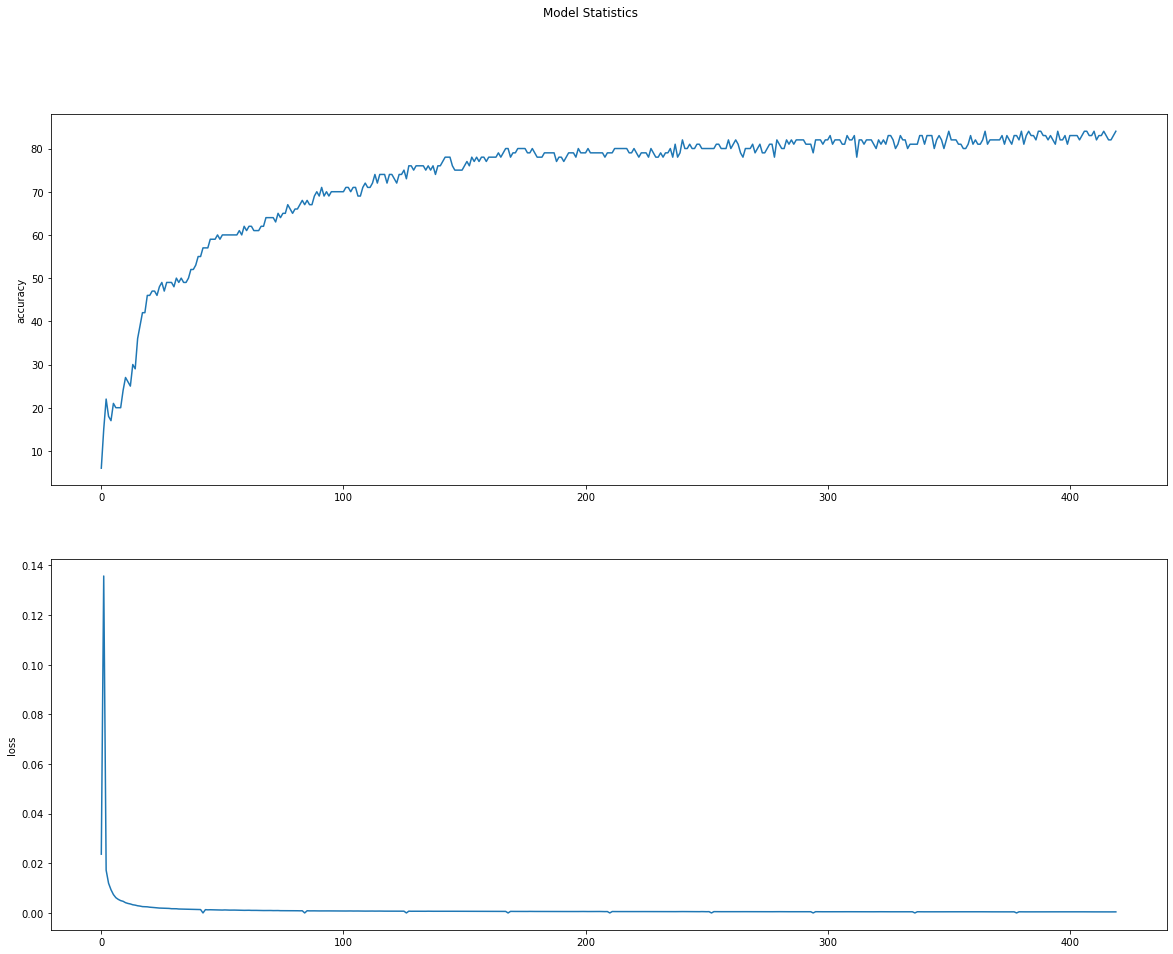

In [58]:
%matplotlib inline

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,15))

fig.suptitle('Model Statistics')

ax1.plot(accuracy)
ax1.set_ylabel('accuracy')

ax2.plot(losses)
ax2.set_ylabel('loss')

plt.show()

In [21]:
torch.save(model.state_dict(), 'simplecnn.model')

In [7]:
model = SimpleCNN()
model.load_state_dict(torch.load('simplecnn.model'))
model = model.to(device)
model.eval()

-- init SimpleCNN --


SimpleCNN(
  (conv1): Conv2d(1, 6, kernel_size=(4, 4), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 12, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=432, out_features=100, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)

In [8]:
path_to_test = 'C:/Users/Lauri/condaThings/neural_networks_by_nielsen/data/kaggle/digit-recognizer/test.csv'
mylib.make_mnist_kaggle_submission(model, path_to_test, device, 'auto_submission.csv')